# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Note that this is a ternary classification problem.

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



## Import packages

In [1]:
import pandas as pd
import numpy as np
import zipfile
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sin City

## Data

#### Import Data

In [2]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [3]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [4]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Map

In [5]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]
df_loc.status_group.value_counts()

functional                 31389
non functional             22268
functional needs repair     3931
Name: status_group, dtype: int64

In [6]:
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [7]:
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

In [8]:
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
geo_df.crs

{'init': 'epsg:4326'}

In [9]:
geo_df.to_crs(epsg = 3857)

RuntimeError: b'no arguments in initialization list'

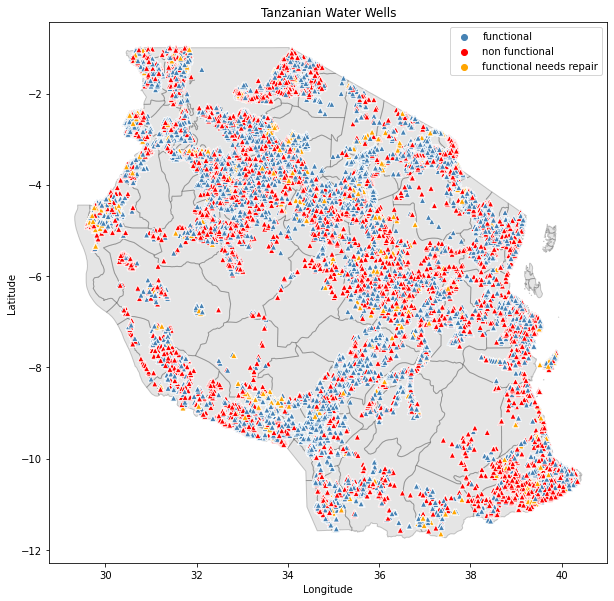

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
geo_df.plot(ax = ax, color = 'grey', edgecolor = 'black', alpha = .2)

colors = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'orange' }
sns.scatterplot(data=df_loc, x = 'longitude', y = 'latitude', marker = '^', alpha = 1,
                hue = df_loc.status_group.tolist(), palette = ['steelblue', 'red', 'orange'])
# ctx.add_basemap(ax, zoom = 10)
plt.title('Tanzanian Water Wells')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

### Data Cleaning

#### Drop Date and NA and unique identifier columns for now

In [11]:
# X.info()

In [12]:
columns_with_na = ['permit', 'scheme_name', 'scheme_management', 'public_meeting', 'subvillage', 'installer', 'funder']
columns_with_specific_location_and_names = ['ward', 'wpt_name']

In [13]:
X.drop(columns_with_na, axis=1, inplace=True)

In [14]:
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [15]:
X.drop('date_recorded', axis=1, inplace=True)

### EDA Visuals

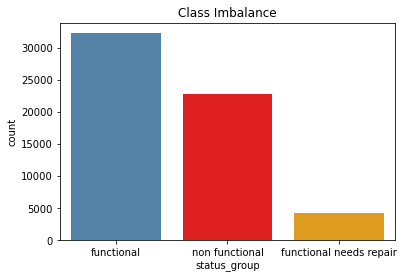

In [16]:
sns.countplot(y, palette = ['steelblue', 'red', 'orange'])
plt.title('Class Imbalance');

## Preprocess Data for Model

#### Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

#### Split Data into continuous and categorical

In [18]:
X.dtypes.value_counts()

object     20
int64       6
float64     3
dtype: int64

In [19]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_cont = X_train.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')
X_test_cont = X_test.select_dtypes(exclude='object')

#### Simple Imputer to fill null numeric values

In [20]:
si = SimpleImputer()
X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)

#### Standard Scaler to scale numeric values

In [21]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)

#### OneHotEncoder for categorical columns

In [22]:
# X_train_cat.info()

In [ ]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                          columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                          columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)

#### Join numeric and object DataFrames back together after preprocessing

In [24]:
X_train_fin = X_train_sc.join(X_train_ohe)
X_test_fin = X_test_sc.join(X_test_ohe)

NameError: name 'X_test_ohe' is not defined

## Modeling

#### Create a Baseline Model

In [25]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_fin, y_train)
lr.score(X_train_fin, y_train)

0.7494276094276094

#### Score model on training data

In [ ]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print('Scores for our training data')
print('Accuracy Score: ' + str(accuracy_score(y_train, y_pred)))

In [ ]:
val = cross_val_score(lr, X_train_fin, y_train, cv=5)
val

#### Score model on testing data

In [ ]:
lr.score(X_test_fin, y_test)

In [ ]:
lr.coef